# Document Understanding Transformer (Donut)
> quick intro by ClovaAI

Document Understanding Transformer (Donut) is a new Transformer model for OCR-free document understanding. It doesn't require an OCR engine to process scanned documents but is achieving state-of-the-art performances on various visual document understanding tasks, such as visual document classification or information extraction (a.k.a. document parsing). 
Donut is a multimodal sequence-to-sequence model with a vision encoder ([Swin Transformer](https://huggingface.co/docs/transformers/v4.21.2/en/model_doc/swin#overview)) and text decoder ([BART](https://huggingface.co/docs/transformers/v4.21.2/en/model_doc/bart)). The encoder receives the images and computes it into an embedding, which is then passed to the decoder, which generates a sequence of tokens.

* Paper: https://arxiv.org/abs/2111.15664
* Official repo:  https://github.com/clovaai/donut

---

### Main step:

- Load the custom dataset and make it in the rigth format
- Load the model and processor
- Create pytorch dataset
- Create PyTorch DataLoader
- Define LightningModule
- Training
- Evaluation

---

#### Starting point

First, let's install the relevant libraries:
* 🤗 Transformers, for the model
* 🤗 Datasets, for loading + processing the data
* PyTorch Lightning, for training the model 
* Weights and Biases, for logging metrics during training
* Sentencepiece, used for tokenization.

We'll use PyTorch Lightning for training here, but note that this is optional, you can of course also just train in native PyTorch or use 🤗 Accelerate, or the 🤗 Trainer

In [1]:
!pip install -q transformers datasets sentencepiece

In [2]:
!pip install -q pytorch-lightning wandb

## Load dataset

We will load a version of the custom dataset from my google drive. To the google collab. And then get in the correct directory to then work with it. Also do some cleanups of useless files.

In [ ]:
from google.colab import drive
# Mount the google drive
drive.mount('/content/drive')

# Change directory to the data directory
%cd /content/drive/MyDrive/data

### Formatting the dataset lables

We import the dataset lables in the format given to us in `csv` and load them into a pandas dataframe to be able to work with the with more ease. We also do some cleanup by setting NaN for unlabled tags. By looking around I found that there are 204 nan media type: 

```python
# Get the unique values of the 'mediaType' column
media_types = df['mediaType'].unique()

# Print the unique values
print(media_types)

none_count = df['mediaType'].isnull().sum()

print(none_count) # 204
```

In [2]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import json
import os

# Change direcotry
%cd /Volumes/JACZAC_STORAGE/Thesis\ Data

# Read the csv file
df = pd.read_csv('test.csv', delimiter=';')

# Select only the first 5 rows of the dataframe
# df = df.head(5)

column_names = df.columns.tolist()

# Print the column names
print(column_names)

# print(df)

/Volumes/JACZAC_STORAGE/Thesis Data
['catalogNumber', 'recordedBy', 'eventDate', 'year', 'month', 'day', 'verbatimEventDate', 'locality', 'decimalLatitude', 'decimalLongitude', 'identifiedBy', 'elevation', 'elevationAccuracy', 'mediaType', 'verbatimScientificName']


### Creating the metadata.json

We have a folder with images and we want to create the `metadata.json` file  which associate text from the dataframe to the images as ground truth. This is necessary for the `imagefolder` feature of `datasets`.

The `metadata.json` should look at the end similar to the example below.

```json
{"file_name": "0001.png", "ground_truth": "This is a golden retriever playing with a ball"}
{"file_name": "0002.png", "ground_truth": "A german shepherd"}
```

In our example will `"text"` column contain the OCR text of the image, which will later be used for creating the Donut specific format.

In [12]:
from pathlib import Path

# define paths
image_path = "img"

# define metadata list
metadata_list = []

# loop through rows of dataframe
for index, row in df.iterrows():
    # Do it only for the ones who have null note and others to avoid wierd things
    if row['mediaType'] == "StillImage": # and pd.isnull(row['Determinavit']) and pd.isnull(row['Legit']):
       
        # Fill the NaN in the row wiht the empty string
        row = row.fillna(' ')
        
        # create dictionary with metadata for this row
        metadata_dict = {
            "Nome_verbatim": row['verbatimScientificName'],
            "Locality": row['locality'],
            "Elevation": row['elevation'],
            "Day": row['day'],
            "Month": row['month'],
            "Year": row['year'],
        }
        # create dictionary with "file_name" and "text" keys
        metadata_list.append({
            "ground_truth": json.dumps(metadata_dict),
            "file_name": f"pi_{str(row['catalogNumber']).zfill(6)}.jpg"
        })

# write jsonline file to the image_path
jsonl_file_path = os.path.join(image_path, 'metadata.jsonl')
with open(jsonl_file_path, 'w') as outfile:
    for entry in metadata_list:
        json.dump(entry, outfile)
        outfile.write('\n')

#### Delete images that are not in the metadata.json

---

After I have created a copy I can delete the images that are not in the metadata from the folder that I actually use

In [13]:
import shutil
# create a copy of the 'data' directory as 'img_copy'
# shutil.copytree('/content/drive/MyDrive/data/img', '/content/drive/MyDrive/img_copy')

metadata_file = "img/metadata.jsonl"
image_path = "img/"

# Load the list of image files from the metadata file
with open(metadata_file, 'r') as f:
    metadata_list = [json.loads(line)['file_name'] for line in f]

# Count the number of deleted files
deleted_count = 0

# Create a progress bar
with tqdm(total=len(os.listdir(image_path)), desc="Deleting files") as pbar:
    # Delete image files that don't have metadata
    for file_name in os.listdir(image_path):
        if file_name.endswith('.jpg') and file_name not in metadata_list:
            os.remove(os.path.join(image_path, file_name))
            deleted_count += 1
        pbar.update(1)

print(f"Number of files deleted: {deleted_count}")

Number of files deleted: 387


#### Show evertyhing that is not jpeg

In [16]:
image_path = "img/"

# Show files that are not JPEG
for filename in os.listdir(image_path):
    if not filename.endswith(".jpeg") and not filename.endswith(".jpg"):
        print(filename)

metadata.jsonl


#### Convert tiff images to jpeg

In [20]:
from PIL import Image

# Convert TIFF images to JPEG and remove TIFF images
jpg_files = [filename for filename in os.listdir(image_path) if filename.endswith((".tiff", ".tif"))]

with tqdm(total=len(jpg_files), desc="Converting images") as pbar:
    for filename in jpg_files:
        tiff_path = os.path.join(image_path, filename)
        jpeg_path = os.path.join(image_path, os.path.splitext(filename)[0] + ".jpg")
        im = Image.open(tiff_path)
        im.save(jpeg_path, "JPEG")
        os.remove(tiff_path)
        pbar.update(1)

print("Conversion complete.")

#### Remove metadata that are not present

---
Just to be sure there is not anything wierd

In [28]:
# Check if the directory exists, if not, create it
if not os.path.exists(image_path):
    os.makedirs(image_path)

# Get the list of jpg files in the directory
jpg_files = [f for f in os.listdir(image_path) if f.endswith('.jpg')]

# Load the metadata from the metadata file
with open(metadata_file, 'r') as f:
    metadata_list = [json.loads(line) for line in f]

# Filter the metadata to keep only the ones with file names present in the directory
filtered_metadata = []
with tqdm(total=len(metadata_list), desc="Filtering metadata") as pbar:
    for metadata in metadata_list:
        if metadata['file_name'] in jpg_files:
            filtered_metadata.append(metadata)
        pbar.update(1)

# Save the filtered metadata to a new file
with open(os.path.join(image_path, "filtered_metadata.jsonl"), "w") as f:
    for metadata in filtered_metadata:
        f.write(json.dumps(metadata) + "\n")
        
# Replace the original metadata file with the filtered version
os.replace(filtered_metadata_file, metadata_file)

# Remove the filtered metadata file
os.remove(filtered_metadata_file)

print(f"Number of metadata entries kept: {len(filtered_metadata)}")

Filtering metadata: 100%|██████████████████████████████| 52274/52274 [00:02<00:00, 19775.93it/s]

Number of metadata entries kept: 5704


#### Smaller image size dataset

Create a copy of the images with a half of the size and rotate them in necessary do everything with a progressbar

In [ ]:
from PIL import Image
import shutil
import os
from tqdm import tqdm

# Define the paths for the input and output directories
input_dir = "img"
output_dir = "img_resized/"

# Create the output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Get the list of image files in the input directory
image_files = [filename for filename in os.listdir(input_dir) if filename.endswith(".jpg")]

# Loop through all the image files in the input directory with a progress bar
for filename in tqdm(image_files, desc="Processing images"):
    # Open the image and resize it
    with Image.open(os.path.join(input_dir, filename)) as img:
        resized_img = img.resize((1200, 1600))
        
        # Save the resized image to the output directory
        exif_data = img.info.get('exif')
        if exif_data is not None:
            resized_img.save(os.path.join(output_dir, filename), exif=exif_data)
        else:
            resized_img.save(os.path.join(output_dir, filename))

# Copy the metadata file to the output directory
shutil.copyfile("img/metadata.jsonl", "img_resized/metadata.jsonl")

### Prepare train, validation, and test splits

In this code cell, we load a dataset of images and metadata from a JSONL file, and then split it into three subsets for training, validation, and testing. We use the `train_test_split` function from scikit-learn to perform the splits, with a random seed for reproducibility.

After creating the splits, we create three new directories for each subset, and move the corresponding images and metadata files into each directory. We use a loop to copy the images to the new directories, renaming them if necessary, and create new metadata files for each subset.

The resulting directory structure should be as follows:

- `img/train` contains the training images and metadata 70%
- `img/val` contains the validation images and metadata 15%
- `img/test` contains the test images and metadata 15%

The metadata files are in the JSONL format, with each line representing a dictionary containing information about each image, such as the filename, label, and other metadata.

In [5]:
import random
from pathlib import Path
from sklearn.model_selection import train_test_split
from tqdm import tqdm

image_path = "img_resized/"

# Set random seed for reproducibility
seed = 1337

# load metadata from JSONL file
metadata_list = []
with open(os.path.join(image_path, 'metadata.jsonl'), 'r') as infile:
    for line in infile:
        metadata_list.append(json.loads(line.strip()))

# Split the dataset into train, validation and test
train_metadata, temp_metadata = train_test_split(metadata_list, test_size=0.3, random_state=seed)
val_metadata, test_metadata = train_test_split(temp_metadata, test_size=0.5, random_state=seed)

# create directories
os.makedirs(os.path.join(image_path, 'train'), exist_ok=True)
os.makedirs(os.path.join(image_path, 'val'), exist_ok=True)
os.makedirs(os.path.join(image_path, 'test'), exist_ok=True)

# Define directories and corresponding metadata
dirs = ['train', 'val', 'test']
metadata = [train_metadata, val_metadata, test_metadata]

# Loop over directories and metadata, copy images and create metadata file
for directory, data in zip(dirs, metadata):
    metadata_list = []
    for entry in tqdm(data, desc=f"Processing {directory}"):
        src_file_path = os.path.join(image_path, entry['file_name'])
        dst_file_path = os.path.join(image_path, directory, entry['file_name'])
        os.rename(src_file_path, dst_file_path)
        metadata_list.append(entry)
    
    with open(os.path.join(image_path, directory, 'metadata.jsonl'), 'w') as outfile:
        for entry in metadata_list:
            json.dump(entry, outfile)
            outfile.write('\n')

Processing test: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 856/856 [00:00<00:00, 28889.69it/s]


## 3. Creating dataset

> This is a good starting point if your dataset is already formatted correctly

Since our custom dataset is not compatible with Donut, we will use the `imagefolder` feature of the `datasets` library to load the dataset into our model. 
Now we can load the dataset using the `imagefolder` feature of `datasets`.
___

#### Notes
This might be interesting [sparrow](https://github.com/katanaml/sparrow)

In [6]:
# Delete in case of cached dataset
!rm -rf /root/.cache/huggingface/datasets/imagefolder/default-5a4ceb57f781cbf0/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f
# !rm -rf /content/drive/MyDrive/data/img_resized

In [7]:
from pathlib import Path
from datasets import load_dataset
import json

# image_path = base_path.joinpath("img")
image_path = "img_resized"

dataset = load_dataset(image_path)

print(f'this is the dataset {dataset}')

Resolving data files:   0%|          | 0/3993 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/857 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/857 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

this is the dataset DatasetDict({
    train: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 3992
    })
    validation: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 856
    })
    test: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 856
    })
})


#### Show an example

Now, lets take a closer look at our dataset by showing an example

Random sample is 3922
OCR text is {"Nome_verbatim": "Festuca inops De Not.", "Locality": "[label:Erbario P. Pellegrini], pascoli di montagna a Pascoso presso Pescaglia (Lucca)", "Elevation": " ", "Day": " ", "Month": 7.0, "Year": 1915.0}


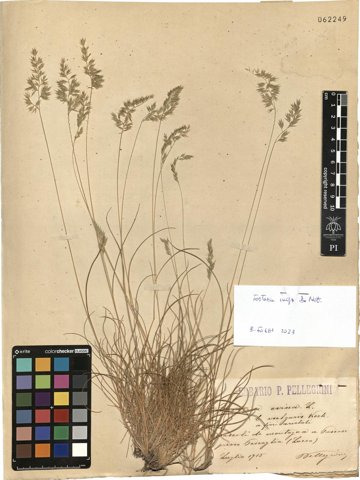

In [12]:
import random

random_sample = random.randint(0, len(dataset['train']))

example = dataset['train'][random_sample]
image = example['image']
ground_truth = example['ground_truth']
 
# Print the nmae of the sample
print(f"Random sample is {random_sample}")
        
# let's load the corresponding JSON dictionary (as string representation)
print(f"OCR text is {ground_truth}")

# let's make the image a bit smaller when visualizing
width, height = image.size
display(image.resize((int(width*0.3), int(height*0.3))))

We can also parse the string as a Python dictionary using `ast.literal_eval`. Each training example has a single "gt_parse" key, which contains the ground truth parsing of the document:

In [ ]:
from ast import literal_eval

literal_eval(ground_truth)

## Load model and processor

Next, we load the model (Donut is an instance of [VisionEncoderDecoderModel](https://huggingface.co/docs/transformers/model_doc/vision-encoder-decoder)), and the processor, which is the object that can be used to prepare inputs for the model.

We'll update some settings for fine-tuning, namely the image size and the max length of the decoder.

In [ ]:
from transformers import VisionEncoderDecoderConfig

image_size = [1600, 1200]
max_length = 1024

# update image_size of the encoder
# during pre-training, a larger image size was used
config = VisionEncoderDecoderConfig.from_pretrained("naver-clova-ix/donut-base")
config.encoder.image_size = image_size # (height, width)
# update max_length of the decoder (for generation)
config.decoder.max_length = max_length
# TODO we should actually update max_position_embeddings and interpolate the pre-trained ones:
# https://github.com/clovaai/donut/blob/0acc65a85d140852b8d9928565f0f6b2d98dc088/donut/model.py#L602

Next, we instantiate the model with our custom config, as well as the processor. Make sure that all pre-trained weights are correctly loaded (a warning would tell you if that's not the case).

In [ ]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base", config=config)

## Create PyTorch dataset

Here we create a regular PyTorch dataset.

The model doesn't directly take the (image, JSON) pairs as input and labels. Rather, we create `pixel_values` and `labels`. Both are PyTorch tensors. The `pixel_values` are the input images (resized, padded and normalized), and the `labels` are the `input_ids` of the target sequence (which is a flattened version of the JSON), with padding tokens replaced by -100 (to make sure these are ignored by the loss function). Both are created using `DonutProcessor` (which internally combines an image processor, for the image modality, and a tokenizer, for the text modality).

Note that we're also adding tokens to the vocabulary of the decoder (and corresponding tokenizer) for all keys of the dictionaries in our dataset, like "\<s_menu>". This makes sure the model learns an embedding vector for them. Without doing this, some keys might get split up into multiple subword tokens, in which case the model just learns an embedding for the subword tokens, rather than a direct embedding for these keys.

In [ ]:
import json
import random
from typing import Any, List, Tuple

import torch
from torch.utils.data import Dataset

added_tokens = []

class DonutDataset(Dataset):
    """
    PyTorch Dataset for Donut. This class takes a HuggingFace Dataset as input.
    
    Each row, consists of image path(png/jpg/jpeg) and gt data (json/jsonl/txt),
    and it will be converted into pixel_values (vectorized image) and labels (input_ids of the tokenized string).
    
    Args:
        dataset_name_or_path: name of dataset (available at huggingface.co/datasets) or the path containing image files and metadata.jsonl
        max_length: the max number of tokens for the target sequences
        split: whether to load "train", "validation" or "test" split
        ignore_id: ignore_index for torch.nn.CrossEntropyLoss
        task_start_token: the special token to be fed to the decoder to conduct the target task
        prompt_end_token: the special token at the end of the sequences
        sort_json_key: whether or not to sort the JSON keys
    """

    def __init__(
        self,
        dataset_name_or_path: str,
        max_length: int,
        split: str = "train",
        ignore_id: int = -100,
        task_start_token: str = "<s>",
        prompt_end_token: str = None,
        sort_json_key: bool = True,
    ):
        super().__init__()

        self.max_length = max_length
        self.split = split
        self.ignore_id = ignore_id
        self.task_start_token = task_start_token
        self.prompt_end_token = prompt_end_token if prompt_end_token else task_start_token
        self.sort_json_key = sort_json_key

        self.dataset = load_dataset(dataset_name_or_path, split=self.split)
        self.dataset_length = len(self.dataset)

        self.gt_token_sequences = []
        for sample in self.dataset:
            ground_truth = json.loads(sample["ground_truth"])
            if 'gt_parse' not in ground_truth and 'gt_parses' not in ground_truth:
                # If the ground truth is already a string then just save that
                gt_jsons = [ground_truth]
            else:
                if "gt_parses" in ground_truth:  # when multiple ground truths are available, e.g., docvqa
                    assert isinstance(ground_truth["gt_parses"], list)
                    gt_jsons = ground_truth["gt_parses"]
                else:
                    assert "gt_parse" in ground_truth and isinstance(ground_truth["gt_parse"], dict)
                    gt_jsons = [ground_truth["gt_parse"]]

            # Add the tokens indipentently of how they are created
            self.gt_token_sequences.append(
                [
                    self.json2token(
                        gt_json,
                        update_special_tokens_for_json_key=self.split == "train",
                        sort_json_key=self.sort_json_key,
                    )
                    + processor.tokenizer.eos_token
                    for gt_json in gt_jsons  # load json from list of json
                ]
             )

        self.add_tokens([self.task_start_token, self.prompt_end_token])
        self.prompt_end_token_id = processor.tokenizer.convert_tokens_to_ids(self.prompt_end_token)

    def json2token(self, obj: Any, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
        """
        Convert an ordered JSON object into a token sequence
        """
        if type(obj) == dict:
            if len(obj) == 1 and "text_sequence" in obj:
                return obj["text_sequence"]
            else:
                output = ""
                if sort_json_key:
                    keys = sorted(obj.keys(), reverse=True)
                else:
                    keys = obj.keys()
                for k in keys:
                    if update_special_tokens_for_json_key:
                        self.add_tokens([fr"<s_{k}>", fr"</s_{k}>"])
                    output += (
                        fr"<s_{k}>"
                        + self.json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                        + fr"</s_{k}>"
                    )
                return output
        elif type(obj) == list:
            return r"<sep/>".join(
                [self.json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
            )
        else:
            obj = str(obj)
            if f"<{obj}/>" in added_tokens:
                obj = f"<{obj}/>"  # for categorical special tokens
            return obj
    
    def add_tokens(self, list_of_tokens: List[str]):
        """
        Add special tokens to tokenizer and resize the token embeddings of the decoder
        """
        newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
        if newly_added_num > 0:
            model.decoder.resize_token_embeddings(len(processor.tokenizer))
            added_tokens.extend(list_of_tokens)
    
    def __len__(self) -> int:
        return self.dataset_length

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Load image from image_path of given dataset_path and convert into input_tensor and labels
        Convert gt data into input_ids (tokenized string)
        Returns:
            input_tensor : preprocessed image
            input_ids : tokenized gt_data
            labels : masked labels (model doesn't need to predict prompt and pad token)
        """
        sample = self.dataset[idx]

        # inputs
        pixel_values = processor(sample["image"], random_padding=self.split == "train", return_tensors="pt").pixel_values
        pixel_values = pixel_values.squeeze()

        # targets
        target_sequence = random.choice(self.gt_token_sequences[idx])  # can be more than one, e.g., DocVQA Task 1
        input_ids = processor.tokenizer(
            target_sequence,
            add_special_tokens=False,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )["input_ids"].squeeze(0)

        labels = input_ids.clone()
        labels[labels == processor.tokenizer.pad_token_id] = self.ignore_id  # model doesn't need to predict pad token
        # labels[: torch.nonzero(labels == self.prompt_end_token_id).sum() + 1] = self.ignore_id  # model doesn't need to predict prompt (for VQA)
        return pixel_values, labels, target_sequence

Next, we instantiate the datasets:

In [ ]:
# we update some settings which differ from pretraining; namely the size of the images + no rotation required
# source: https://github.com/clovaai/donut/blob/master/config/train_cord.yaml
processor.image_processor.size = image_size[::-1] # should be (width, height)
processor.image_processor.do_align_long_axis = False

train_dataset = DonutDataset(image_path, max_length=max_length,
                             split="train", task_start_token="<s_herbarium>", prompt_end_token="<s_herbarium>",
                             sort_json_key=False, # cord dataset is preprocessed, so no need for this
                             )

val_dataset = DonutDataset(image_path, max_length=max_length,
                             split="validation", task_start_token="<s_herbarium>", prompt_end_token="<s_herbarium>",
                             sort_json_key=False, # cord dataset is preprocessed, so no need for this
                             )

Let's check which tokens are added:

In [ ]:
print(added_tokens)

In [ ]:
# the vocab size attribute stays constants (might be a bit unintuitive - but doesn't include special tokens)
print("Original number of tokens:", processor.tokenizer.vocab_size)
print("Number of tokens after adding special tokens:", len(processor.tokenizer))

As always, it's very important to verify whether our data is prepared correctly. Let's check the first training example:

In [ ]:
pixel_values, labels, target_sequence = train_dataset[0]

This returns the `pixel_values` (the image, but prepared for the model as a PyTorch tensor), the `labels` (which are the encoded `input_ids` of the target sequence, which we want Donut to learn to generate) and the original `target_sequence`. The reason we also return the latter is because this will allow us to compute metrics between the generated sequences and the ground truth target sequences.

In [ ]:
print(pixel_values.shape)

Another important thing is that we need to set 2 additional attributes in the configuration of the model. This is not required, but will allow us to train the model by only providing the decoder targets, without having to provide any decoder inputs.

The model will automatically create the `decoder_input_ids` (the decoder inputs) based on the `labels`, by shifting them one position to the right and prepending the decoder_start_token_id. I recommend checking [this video](https://www.youtube.com/watch?v=IGu7ivuy1Ag&t=888s&ab_channel=NielsRogge) if you want to understand how models like Donut automatically create decoder_input_ids - and more broadly how Donut works.

In [ ]:
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(['<s_herbarium>'])[0]

In [ ]:
# sanity check
print("Pad token ID:", processor.decode([model.config.pad_token_id]))
print("Decoder start token ID:", processor.decode([model.config.decoder_start_token_id]))

## Create PyTorch DataLoaders

Next, we create corresponding PyTorch DataLoaders, which allow us to loop over the dataset in batches:

In [ ]:
from torch.utils.data import DataLoader

# feel free to increase the batch size if you have a lot of memory
# I'm fine-tuning on Colab and given the large image size, batch size > 1 is not feasible
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)

Let's verify a batch:

In [ ]:
batch = next(iter(train_dataloader))
pixel_values, labels, target_sequences = batch
print(pixel_values.shape)

In [ ]:
for id in labels.squeeze().tolist()[:30]:
  if id != -100:
    print(processor.decode([id]))
  else:
    print(id)

In [ ]:
print(len(train_dataset))
print(len(val_dataset))

In [ ]:
# let's check the first validation batch
batch = next(iter(val_dataloader))
pixel_values, labels, target_sequences = batch
print(pixel_values.shape)

In [ ]:
print(target_sequences[0])

## Define LightningModule

Next, we define a [LightningModule](https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html), which is the standard way to train a model in PyTorch Lightning. A LightningModule is an `nn.Module` with some additional functionality. 

Basically, PyTorch Lightning will take care of all device placements (`.to(device)`) for us, as well as the backward pass, putting the model in training mode, etc.

In [ ]:
from pathlib import Path
import re
from nltk import edit_distance
import numpy as np
import math

from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import LambdaLR

import pytorch_lightning as pl
from pytorch_lightning.utilities import rank_zero_only


class DonutModelPLModule(pl.LightningModule):
    def __init__(self, config, processor, model):
        super().__init__()
        self.config = config
        self.processor = processor
        self.model = model

    def training_step(self, batch, batch_idx):
        pixel_values, labels, _ = batch
        
        outputs = self.model(pixel_values, labels=labels)
        loss = outputs.loss
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx, dataset_idx=0):
        pixel_values, labels, answers = batch
        batch_size = pixel_values.shape[0]
        # we feed the prompt to the model
        decoder_input_ids = torch.full((batch_size, 1), self.model.config.decoder_start_token_id, device=self.device)
        
        outputs = self.model.generate(pixel_values,
                                   decoder_input_ids=decoder_input_ids,
                                   max_length=max_length,
                                   early_stopping=True,
                                   pad_token_id=self.processor.tokenizer.pad_token_id,
                                   eos_token_id=self.processor.tokenizer.eos_token_id,
                                   use_cache=True,
                                   num_beams=1,
                                   bad_words_ids=[[self.processor.tokenizer.unk_token_id]],
                                   return_dict_in_generate=True,)
    
        predictions = []
        for seq in self.processor.tokenizer.batch_decode(outputs.sequences):
            seq = seq.replace(self.processor.tokenizer.eos_token, "").replace(self.processor.tokenizer.pad_token, "")
            seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
            predictions.append(seq)

        scores = []
        for pred, answer in zip(predictions, answers):
            pred = re.sub(r"(?:(?<=>) | (?=</s_))", "", pred)
            # NOT NEEDED ANYMORE
            # answer = re.sub(r"<.*?>", "", answer, count=1)
            answer = answer.replace(self.processor.tokenizer.eos_token, "")
            scores.append(edit_distance(pred, answer) / max(len(pred), len(answer)))

            if self.config.get("verbose", False) and len(scores) == 1:
                pass
                # print(f"Prediction: {pred}")
                # print(f"    Answer: {answer}")
                print(f" Normed ED: {scores[0]}")

        self.log("val_edit_distance", np.mean(scores))
        
        return scores

    def configure_optimizers(self):
        # you could also add a learning rate scheduler if you want
        optimizer = torch.optim.Adam(self.parameters(), lr=self.config.get("lr"))
    
        return optimizer

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

## Train!

Next, let's train! This happens instantiating a PyTorch Lightning `Trainer`, and then calling `trainer.fit`.

What's great is that we can automatically train on the hardware we have (in our case, a single GPU), enable mixed precision (`fp16=True`, which makes sure we don't consume as much memory), add Weights and Biases logging, and so on. 

In [ ]:
config = {"max_epochs":25,
          "val_check_interval":0.25, # how many times we want to validate during an epoch
          "check_val_every_n_epoch":1,
          "gradient_clip_val":1.0,
          "num_training_samples_per_epoch": 1460,
          "lr":3e-5,
          "train_batch_sizes": [8],
          "val_batch_sizes": [1],
          # "seed":2022,
          "num_nodes": 1,
          "warmup_steps": 600, # 800/8*30/10, 10%
          "result_path": "./result",
          "verbose": True,
          }

model_module = DonutModelPLModule(config, processor, model)

We'll use a custom callback to push our model to the hub during training (after each epoch + end of training). For that we'll log into our HuggingFace account.

In [ ]:
!huggingface-cli login

In [ ]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import Callback, EarlyStopping

wandb_logger = WandbLogger(project="Donut", name="thesis_test_donut")

class PushToHubCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        print(f"Pushing model to the hub, epoch {trainer.current_epoch}")
        pl_module.model.push_to_hub("Jac-Zac/thesis_test_donut",
                                    commit_message=f"Training in progress, epoch {trainer.current_epoch}")

    def on_train_end(self, trainer, pl_module):
        print(f"Pushing model to the hub after training")
        pl_module.processor.push_to_hub("Jac-Zac/thesis_test_donut",
                                    commit_message=f"Training done")
        pl_module.model.push_to_hub("Jac-Zac/thesis_test_donut",
                                    commit_message=f"Training done")

early_stop_callback = EarlyStopping(monitor="val_edit_distance", patience=3, verbose=False, mode="min")

trainer = pl.Trainer(
        accelerator="gpu",
        devices=1,
        max_epochs=config.get("max_epochs"),
        val_check_interval=config.get("val_check_interval"),
        check_val_every_n_epoch=config.get("check_val_every_n_epoch"),
        gradient_clip_val=config.get("gradient_clip_val"),
        precision=16, # we'll use mixed precision
        num_sanity_val_steps=0,
        logger=wandb_logger,
        callbacks=[PushToHubCallback(), early_stop_callback],
)

# Train the model from scratch
# trainer.fit(model_module)
# Train the model from a checkpoint
trainer.fit(model_module, ckpt_path = "some_path/checkpoint.ckpt")

## Evaluate

After training, we can evaluate the model on the test set.

As we pushed the model to the hub, we can very easily load it back again using the `from_pretrained` method. You can see the files in this [repo](https://huggingface.co/Jac-Zac/thesis_test_donut).




Note that you can also easily refer to a specific commit in the `from_pretrained` method using the [`revision`](https://huggingface.co/docs/transformers/v4.21.1/en/main_classes/model#transformers.PreTrainedModel.from_pretrained.revision) argument, or use the private hub in case you'd like to keep your models private and only shared with certain colleagues for instance.

Here we're just loading from the main branch, which means the latest commit.

In [ ]:
!huggingface-cli login

In [ ]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

processor = DonutProcessor.from_pretrained("Jac-Zac/thesis_test_donut")
model = VisionEncoderDecoderModel.from_pretrained("Jac-Zac/thesis_test_donut")

As we don't have a test split here, let's evaluate on the validation split.

We'll use the `token2json` method of the processor to turn the generated sequences into JSON, and the `JSONParseEvaluator` object available in the Donut package.

In [ ]:
!pip install -q donut-python

In [ ]:
import re
import json
import torch
from tqdm.auto import tqdm
import numpy as np

from donut import JSONParseEvaluator

from datasets import load_dataset

device = "cuda" if torch.cuda.is_available() else "cpu"

model.eval()
model.to(device)

output_list = []
accs = []

image_path = "img_resized"

dataset = load_dataset(image_path, split="test")


for idx, sample in tqdm(enumerate(dataset), total=len(dataset)):
    # prepare encoder inputs
    pixel_values = processor(sample["image"].convert("RGB"), return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    # prepare decoder inputs
    task_prompt = "<s_herbarium>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids
    decoder_input_ids = decoder_input_ids.to(device)
    
    # autoregressively generate sequence
    outputs = model.generate(
            pixel_values,
            decoder_input_ids=decoder_input_ids,
            max_length=model.decoder.config.max_position_embeddings,
            early_stopping=True,
            pad_token_id=processor.tokenizer.pad_token_id,
            eos_token_id=processor.tokenizer.eos_token_id,
            use_cache=True,
            num_beams=1,
            bad_words_ids=[[processor.tokenizer.unk_token_id]],
            return_dict_in_generate=True,
        )

    # turn into JSON
    seq = processor.batch_decode(outputs.sequences)[0]
    seq = seq.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
    seq = processor.token2json(seq)

    ground_truth = json.loads(sample["ground_truth"])
    evaluator = JSONParseEvaluator()
    score = evaluator.cal_acc(seq, ground_truth)

    accs.append(score)
    output_list.append(seq)

scores = {"accuracies": accs, "mean_accuracy": np.mean(accs)}
print(scores, f"length : {len(accs)}")

In [ ]:
print("Mean accuracy:", np.mean(accs))